In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers.experimental.preprocessing import Normalization, RandomFlip, RandomRotation, RandomCrop
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop, RandomZoom, RandomContrast
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline 

## Загружаем данные

In [2]:
!wget https://www.dropbox.com/s/pnq8ej5c9ti1se7/intel_scene.zip?dl=1 -O intel_scene.zip

--2021-05-29 16:29:04--  https://www.dropbox.com/s/pnq8ej5c9ti1se7/intel_scene.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/pnq8ej5c9ti1se7/intel_scene.zip [following]
--2021-05-29 16:29:04--  https://www.dropbox.com/s/dl/pnq8ej5c9ti1se7/intel_scene.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbd3be00d317cfd1c42e6a04824.dl.dropboxusercontent.com/cd/0/get/BPaoWGOdKaTbLTMjUjzOQmXFQVL3IeMUnrCXsEbi2tmEE54TTwmniBebIvIUo6qwE6Lh5sFRWsfK4AQjIZ4y0NF-A26bahaEJiNgLWC4dgQ4wJDM3Q-PvRS_RUtyEQcI7xKQyRywXsAbu4DHwVCAoACt/file?dl=1# [following]
--2021-05-29 16:29:04--  https://ucbd3be00d317cfd1c42e6a04824.dl.dropboxusercontent.com/cd/0/get/BPaoWGOdKaTbLTMjUjzOQmXFQVL3IeMUnrCXsEbi2tmEE54TTwmniBebIvIUo6qwE6Lh5sFRWsfK4AQ

In [3]:
!unzip intel_scene.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train

In [4]:
!ls seg_train/seg_train

buildings  forest  glacier  mountain  sea  street


**Набор данных для обучения**

In [5]:
train_dataset = image_dataset_from_directory('seg_train/seg_train',
                                             subset='training',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=128,
                                             image_size=(256, 256))

Found 14034 files belonging to 6 classes.
Using 12631 files for training.


In [6]:
validation_dataset = image_dataset_from_directory('seg_train/seg_train',
                                             subset='validation',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=128,
                                             image_size=(128, 128))

Found 14034 files belonging to 6 classes.
Using 1403 files for validation.


In [7]:
class_names = train_dataset.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

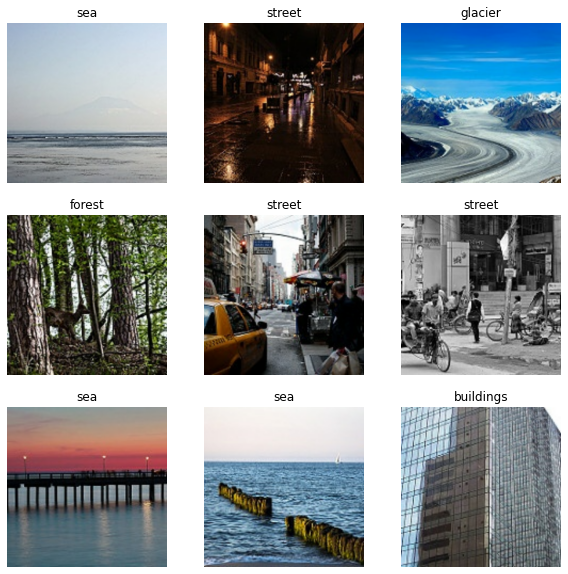

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Набор данных для тестирования**

In [9]:
test_dataset = image_dataset_from_directory('seg_test/seg_test',
                                             shuffle=True,
                                             label_mode='int',
                                             batch_size=128,
                                             image_size=(128, 128))

Found 3000 files belonging to 6 classes.


In [10]:
test_dataset.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Расширение данных

Слои Keras для дополнения данных:

*   [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip) - отражение изображения по горизонтали или вертикали
*   [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomRotation) - поворот изображения
*   [RandomCrop](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomCrop) - вырезание фрагмента изображения из случайного места
*   [CenterCrop](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/CenterCrop) - вырезание фрагмента из центра изображения
*   [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomZoom) - изменние масштаба изображения
*   [RandomContrast](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomContrast) - изменение контраста

Слои применяются только в процессе обучения при вызове `model.fit`. Во время тестирования или распознавания (вызов `model.evaluate` или `model.predict`) слои не работают.



In [12]:
data_augmentation = Sequential()
data_augmentation.add(RandomFlip("horizontal"))
data_augmentation.add(RandomRotation(0.1))
data_augmentation.add(RandomZoom(0.1))
data_augmentation.add(RandomCrop(128, 128))

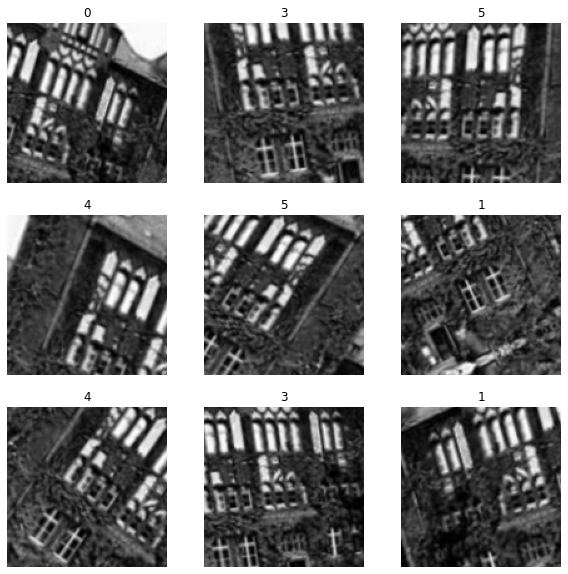

In [13]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Создаем нейронную сеть

In [14]:
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(128, 128, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [15]:
vgg16_net.trainable = False

In [16]:
model = Sequential()
model.add(data_augmentation)
model.add(Normalization())
# Добавляем модель VGG16 в сеть как слой
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

**Компилируем модель**

In [17]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## Обучаем нейронную сеть

In [ ]:
history = model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=15)

## Оцениваем качетсво обучения сети

In [ ]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)

In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

In [ ]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

## Тонкая настройка нейронной сети

In [ ]:
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=3)

## Оцениваем качетсво обучения сети

In [ ]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)

In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

In [ ]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Сохраняем обученную нейронную сеть

In [ ]:
model.save("intel_image_model.h5")

In [ ]:
!ls

Сохраняем модель на локальный компьютер

In [ ]:
files.download("intel_image_model.h5")